In [1]:
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [2]:
class Node:
    def __init__(self, feature=None, threshold=None, left_child=None, right_child=None, value=None):
        self.feature = feature          # Index of the feature for splitting the node
        self.threshold = threshold      # Value of feature used for splitting the node
        self.left = left_child          # Left child: these have vales <= threshold
        self.right = right_child        # Right child: these have vales > threshold
        self.value = value              # This is the predicted value of this wis a leaf node
    
    # This is a method to check if this is a leaf node
    def is_leaf_node(self):
        return self.value is not None

In [3]:
class DecisionTree:
    def __init__(self, min_sample_split=2, n_features=None, random_state=42):
        # Initialize the decision tree parameters
        self.min_samples_split = min_sample_split   # Define the minimum number of samples to split the node
        self.n_features = n_features                # Define the number of features to consider for splitting
        self.root = None                            # Define the root of the decision tree
        self.random_state = random_state            # To ensure reproducability, keep the random_state fixed
        if random_state:
            np.random.seed(random_state)
    
    def fit(self, X, y):
        # Determine the number of features to consider for each split
        self.n_features = X.shape[1] if not self.n_features else min(X.shape[1], self.n_features)
        self.root = self._grow_tree(X, y)       # Grow the decision tree by finding the best split

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_feats = X.shape        # Check the number of sample and features we are working on
        n_labels = len(np.unique(y))        # Find the number of unique labels
        
        # This is the stopping condition, note that here we allow the tree to grow while splitting is possible, we do not do pruning here
        if (n_labels == 1 or n_samples < self.min_samples_split):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        feat_idxs = np.random.choice(n_feats, self.n_features, replace=False)           # Randomly select features for splitting

        best_feature, best_thresh = self._best_split(X, y, feat_idxs)                   # Find the best feature and threshold for splitting

        left_idxs, right_idxs = self._split(X[:, best_feature], best_thresh)            # Split the dataset based on best index and threshold

        if len(left_idxs) == 0 or len(right_idxs) == 0:
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        # Recusrively grow the tree
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth + 1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth + 1)
        return Node(best_feature, best_thresh, left, right)

    def _best_split(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_threshold = None, None
        
        # Iterate over each feature
        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)

            # Calculate information gain for each threshold
            for thr in thresholds:
                gain = self._information_gain(y, X_column, thr)

                # Update the information gain if a better split is found
                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_threshold = thr
        
        return split_idx, split_threshold

    # A function to calculate the entropy
    def _entropy(self, y):
        hist = np.bincount(y)
        ps = hist / len(y)
        return -np.sum([p * np.log2(p) for p in ps if p > 0])

    # A function to calculate the information gain
    def _information_gain(self, y, X_column, threshold):
        parent_entropy = self._entropy(y)                           # Compute the entropy of the parent node

        # Split the data into left and right indexes based on the threshold
        left_idxs, right_idxs = self._split(X_column, threshold)
        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0

        # Find the weighted entropy of the child
        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        e_l, e_r = self._entropy(y[left_idxs]), self._entropy(y[right_idxs])
        child_entropy = (n_l / n) * e_l + (n_r / n) * e_r

        # Return the information gain
        information_gain = parent_entropy - child_entropy
        return information_gain

    def _split(self, X_column, split_thresh):
        # Split the data based in threshold into left and right child indexes
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs

    # Function to extract the most occuring label
    def _most_common_label(self, y):
        counter = Counter(y)
        value = counter.most_common(1)[0][0]
        return value

    # Function to predict label for input samples
    def predict(self, X):
        X = np.atleast_2d(X)
        return np.array([self._traverse_tree(x, self.root) for x in X])
    
    # Function to traverse the node to make predictions
    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value
    
        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

In [ ]:
class RandomForest:
    # Initialize the random forest parametes
    def __init__(self, n_trees=100, min_samples_split=2, n_features=None, random_state=42):
        self.n_trees = n_trees                                      # This defines how many trees build the random forest
        self.min_samples_split = min_samples_split                  # This defines the minimum number of samples to split the node 
        self.n_features = n_features                                # This defines the number of features to consider for splitting
        self.random_state = random_state                            # This defines the random state (to ensure that if anyone else runs the model, answers would be consistent)
        self.trees = []                                             # This stores all the trees built in the random forest process
        self.oob_predictions = []                                   # This is used to calculate the OOB errors            

    def fit(self, X, y):
        np.random.seed(self.random_state)
        self.trees=[]
        # Make n_trees number of trees
        for i in range(self.n_trees):
            this_random_state = self.random_state + i                       # This ensures each tree is independent
            tree = DecisionTree(min_sample_split=self.min_samples_split,n_features=self.n_features, random_state=this_random_state)
            X_sample, y_sample, indexes = self._bootstrap_samples(X, y)     # This will select random samples       
            tree.fit(X_sample, y_sample)                                
            self.trees.append(tree)                                         # Ensure to store this tree in the array

            oob_x = np.delete(X, indexes, axis=0)                           # Only select those indexes which are not selected during bootstrapping
            oob_y = np.delete(y, indexes, axis=0)

            oob_predictions_arr = tree.predict(oob_x)                       # Making predictions on the oob selections we made in the previous step
            oob_predictions = accuracy_score(oob_y, oob_predictions_arr)
            self.oob_predictions.append(1 - oob_predictions)                # Store the OOB error for each tree we make
            

    def _bootstrap_samples(self, X, y):
        n_samples = X.shape[0]
        indexes = np.random.choice(n_samples, n_samples, replace=True)       # select random with replacement
        return X.to_numpy()[indexes], y.to_numpy()[indexes], indexes
    
    def _most_common_label(self, y):
        counter = Counter(y)
        most_common = counter.most_common(1)[0][0]
        return most_common

    def predict(self, X):
        X = np.atleast_2d(X)            # This Ensures X is treated as a 2D array to avoid issues with single samples
        predictions = np.array([tree.predict(X) for tree in self.trees])    # Get predictions from each tree
        tree_predictions = np.swapaxes(predictions, 0, 1)                 
        predictions = np.array([self._most_common_label(tree_pred) for tree_pred in tree_predictions])      # Take majority vote
        return predictions
    
    def oob_error(self):
        return np.mean(self.oob_predictions)

In [ ]:
# URL of the dataset
url = "https://sites.stat.washington.edu/courses/stat527/s14/homework/hw5/spam.data"

# Read the dataset
data = pd.read_csv(url, delimiter=' ', header=None)

print(data.head())

     0     1     2    3     4     5     6     7     8     9   ...    48  \
0  0.00  0.64  0.64  0.0  0.32  0.00  0.00  0.00  0.00  0.00  ...  0.00   
1  0.21  0.28  0.50  0.0  0.14  0.28  0.21  0.07  0.00  0.94  ...  0.00   
2  0.06  0.00  0.71  0.0  1.23  0.19  0.19  0.12  0.64  0.25  ...  0.01   
3  0.00  0.00  0.00  0.0  0.63  0.00  0.31  0.63  0.31  0.63  ...  0.00   
4  0.00  0.00  0.00  0.0  0.63  0.00  0.31  0.63  0.31  0.63  ...  0.00   

      49   50     51     52     53     54   55    56  57  
0  0.000  0.0  0.778  0.000  0.000  3.756   61   278   1  
1  0.132  0.0  0.372  0.180  0.048  5.114  101  1028   1  
2  0.143  0.0  0.276  0.184  0.010  9.821  485  2259   1  
3  0.137  0.0  0.137  0.000  0.000  3.537   40   191   1  
4  0.135  0.0  0.135  0.000  0.000  3.537   40   191   1  

[5 rows x 58 columns]


In [6]:
# Separate features (first 57 columns) and label (last column)
X = data.iloc[:, :-1]  # all columns except the last one
y = data.iloc[:, -1]   # only the last column

In [ ]:
# Split the data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)

def accuracy(y_actual, y_pred):
    accuracy = np.sum(y_actual==y_pred)/len(y_actual)
    return accuracy

In [ ]:
import time

# First lets analyze time related to the model I have built

start_train = time.time()
model = RandomForest()
model.fit(X_train, y_train)
end_train = time.time()

start_test = time.time()
predictions = model.predict(X_test)
end_test = time.time()

# Note that all the times are in seconds
model_accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", model_accuracy)
print("Training Time:", end_train-start_train)
print("Testing Time:",end_test-start_test)

Accuracy: 0.9341057204923968
Training Time: 72.49823307991028
Testing Time: 0.03123784065246582


In [10]:
print(model.oob_error())

0.09418115528173059


0.9029688631426502

In [11]:
from sklearn.ensemble import RandomForestClassifier

start_train = time.time()
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
end_train = time.time()

start_test = time.time()
predictions = rf.predict(X_test)
end_test = time.time()


model_accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", model_accuracy)
print("Training Time:", end_train-start_train)
print("Testing Time:",end_test-start_test)

Accuracy: 0.9514844315713251
Training Time: 0.31179022789001465
Testing Time: 0.010241031646728516


0.9514844315713251

In [12]:
# sensitivity of Random Forests to the parameter m 
sensitivity_to_m = []

for n_features in range(1, X_train.shape[1] + 1):
    start_train = time.time()
    model = RandomForest(n_features=n_features)
    model.fit(X_train, y_train)
    end_train = time.time()

    start_test = time.time()
    predictions = model.predict(X_test)
    end_test = time.time()

    model_accuracy = accuracy_score(y_test, predictions)
    sensitivity_to_m.append(model_accuracy)

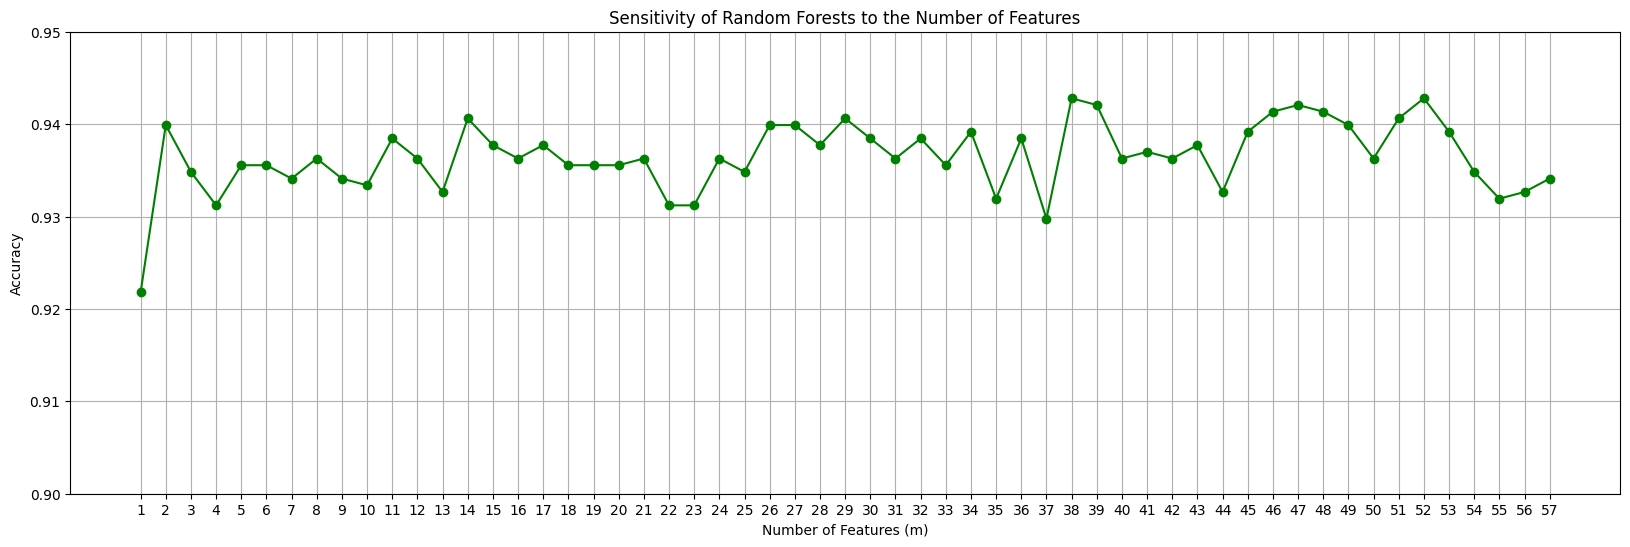

In [ ]:
import matplotlib.pyplot as plt

# Range of feature values corresponding to the accuracies
features_range = list(range(1, X_train.shape[1] + 1))

# Plotting the graph
plt.figure(figsize=(20, 6))
plt.plot(features_range, sensitivity_to_m, marker='o', linestyle='-', color='g')
plt.xlabel("Number of Features (m)")
plt.ylabel("Accuracy")
plt.title("Sensitivity of Random Forests to the Number of Features")
plt.grid(True)
plt.xticks(features_range)  # Show all ticks on the x-axis
plt.ylim(0.9, 0.95)  # Set y-axis limit
plt.show()

In [21]:
# sensitivity of Random Forests to the parameter m 
oob_error_vs_m = []
test_error_vs_m = []

for n_features in range(29, 53):
    start_train = time.time()
    model = RandomForest(n_features=n_features)
    model.fit(X_train, y_train)
    end_train = time.time()

    start_test = time.time()
    predictions = model.predict(X_test)
    end_test = time.time()

    model_accuracy = accuracy_score(y_test, predictions)
    test_error_vs_m.append(1 - model_accuracy)
    oob_error_vs_m.append(model.oob_error())

In [22]:
print(oob_error_vs_m)
print(test_error_vs_m)


[0.09687198534885536, 0.09481903746711126, 0.09336870619938215, 0.08963941948458932, 0.09585524739649535, 0.09712744898872054, 0.09587178690248802, 0.09373658114277252, 0.09513837629629288, 0.09464464706159671, 0.09705508347343395, 0.09522561054193977, 0.09390821391704605, 0.09434001582425863, 0.09282641337233576, 0.09755990472169837, 0.0965224078334648, 0.09331438826518948, 0.09711338322109647, 0.09544881365103008, 0.09496038593357388, 0.09454003151418647, 0.0952067958455268, 0.09624801814376015]
[0.05937726285300504, 0.06154960173787116, 0.06372194062273717, 0.06154960173787116, 0.06444605358435918, 0.06082548877624905, 0.06806661839246919, 0.06154960173787116, 0.07023895727733531, 0.05720492396813903, 0.057929036929761035, 0.06372194062273717, 0.06299782766111517, 0.06372194062273717, 0.062273714699493166, 0.06734250543084719, 0.06082548877624905, 0.05865314989138304, 0.057929036929761035, 0.05865314989138304, 0.060101375814627045, 0.06372194062273717, 0.05937726285300504, 0.0572049

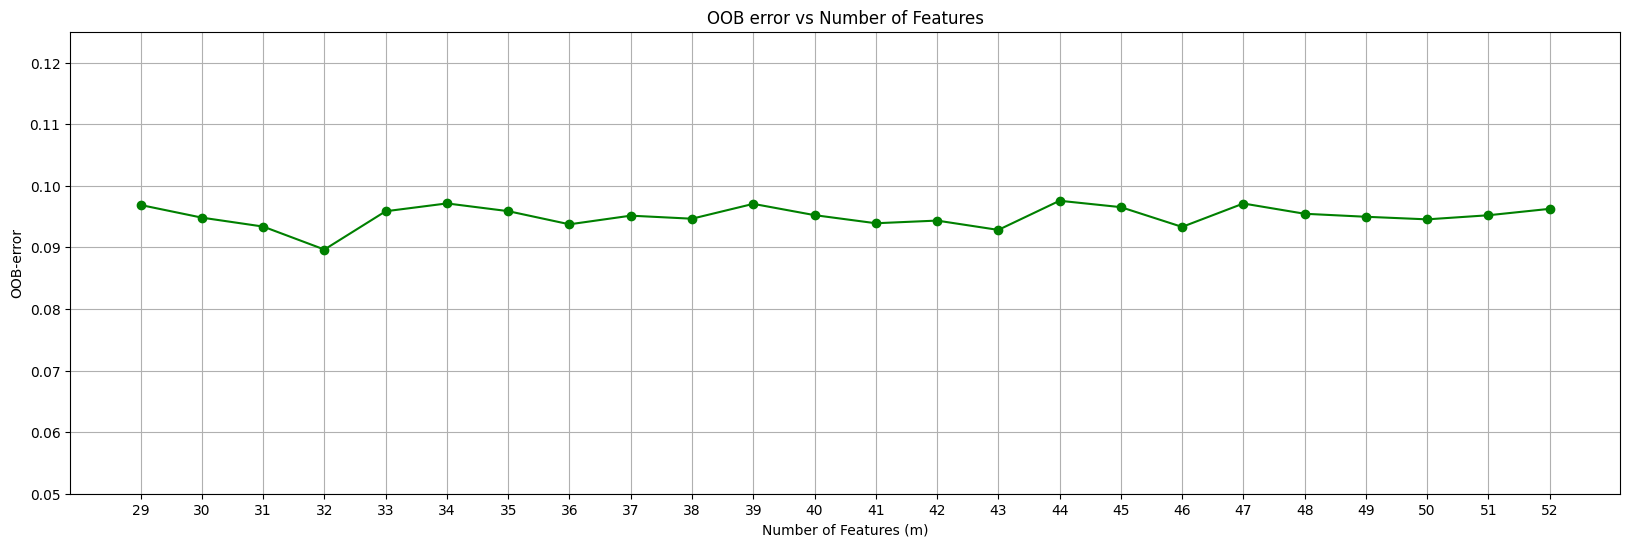

In [ ]:
import matplotlib.pyplot as plt

# Range of feature values corresponding to the accuracies
features_range = list(range(29, 53))

# Plotting the graph
plt.figure(figsize=(20, 6))
plt.plot(features_range, oob_error_vs_m, marker='o', linestyle='-', color='g')
plt.xlabel("Number of Features (m)")
plt.ylabel("OOB-error")
plt.title("OOB error vs Number of Features")
plt.grid(True)
plt.xticks(features_range)  # Show all ticks on the x-axis
plt.ylim(0.05, 0.125)  # Set y-axis limit
plt.show()

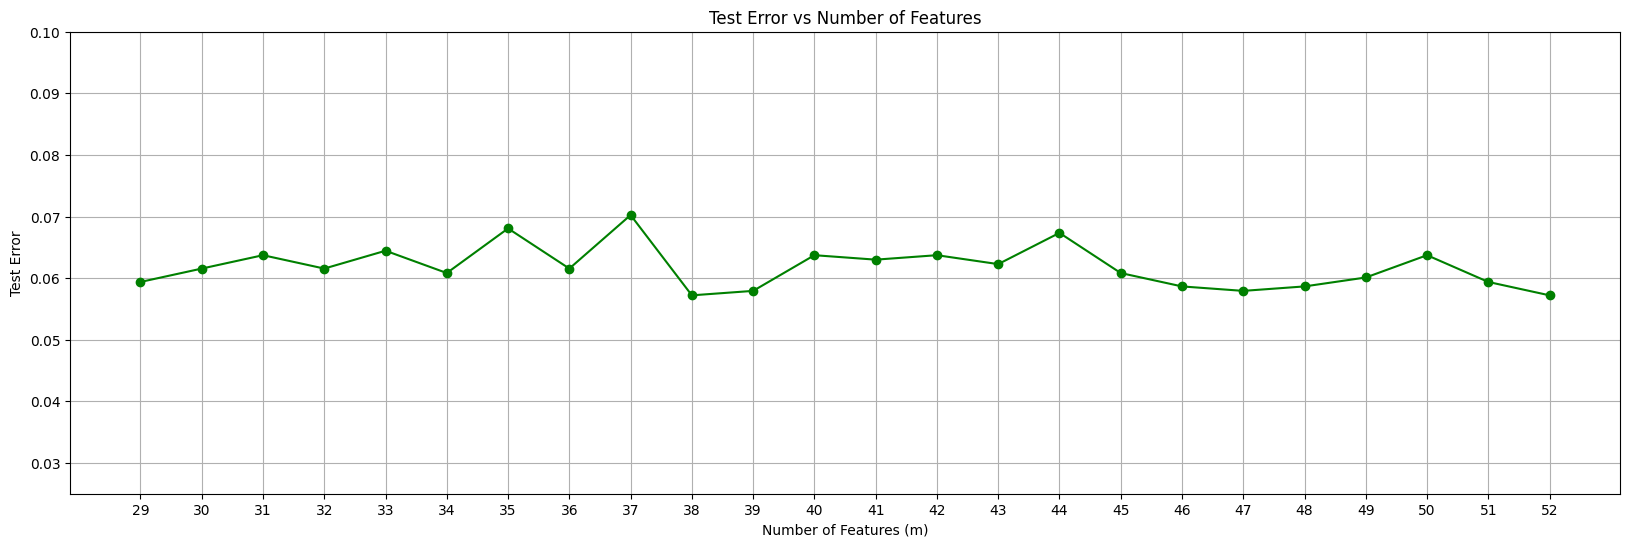

In [ ]:
# Range of feature values corresponding to the accuracies
features_range = list(range(29, 53))

# Plotting the graph
plt.figure(figsize=(20, 6))
plt.plot(features_range, test_error_vs_m, marker='o', linestyle='-', color='g')
plt.xlabel("Number of Features (m)")
plt.ylabel("Test Error")
plt.title("Test Error vs Number of Features")
plt.grid(True)
plt.xticks(features_range)  # Show all ticks on the x-axis
plt.ylim(0.025, 0.1)  # Set y-axis limit
plt.show()

Doing some optimizations

In [29]:
import time

best_accuracy = 0

# First lets analyze time related to the model I have built
for n_tress in [100, 200, 300]:
    for min_sample_split in [2, 3, 4, 5]:
        for n_features in [1, 3, 38, 52]:
            start_train = time.time()
            model = RandomForest(n_trees=n_tress, min_samples_split=min_sample_split, n_features=n_features)
            model.fit(X_train, y_train)
            end_train = time.time()

            start_test = time.time()
            predictions = model.predict(X_test)
            end_test = time.time()

            # Note that all the times are in seconds
            model_accuracy = accuracy_score(y_test, predictions)
            print(f"Accuracy: {model_accuracy}, Training Time: {end_train-start_train}, Testing Time: {end_test-start_test}")
            if model_accuracy > best_accuracy:
                best_accuracy = model_accuracy

Accuracy: 0.9333816075307748, Training Time: 11.359937191009521, Testing Time: 0.22311711311340332
Accuracy: 0.945691527878349, Training Time: 31.664602994918823, Testing Time: 0.3054018020629883
Accuracy: 0.9471397538015931, Training Time: 335.9032530784607, Testing Time: 0.2299332618713379
Accuracy: 0.942795076031861, Training Time: 468.4458417892456, Testing Time: 0.23079800605773926
Accuracy: 0.9341057204923968, Training Time: 13.707287073135376, Testing Time: 0.25688910484313965
Accuracy: 0.942795076031861, Training Time: 35.88980293273926, Testing Time: 0.28119492530822754
Accuracy: 0.9485879797248371, Training Time: 327.78246235847473, Testing Time: 0.2109088897705078
Accuracy: 0.9471397538015931, Training Time: 431.86332178115845, Testing Time: 0.21026396751403809
Accuracy: 0.9297610427226647, Training Time: 12.484040021896362, Testing Time: 0.2478330135345459
Accuracy: 0.944967414916727, Training Time: 35.04820203781128, Testing Time: 0.31282782554626465
Accuracy: 0.9420709630

In [30]:
print(best_accuracy)

0.9485879797248371
